In [1]:
!pip3 install pandas numpy scikit-learn seaborn matplotlib plotly dash folium beautifulsoup4 requests sqlalchemy ipython-sql jupyter openpyxl pyodbc mysql-connector-python psycopg2-binary


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\great\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd
from io import StringIO

In [21]:
def obtener_tiobe_datos():
    url = "https://www.tiobe.com/tiobe-index/"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/90.0 Safari/537.36"
    }
    
    try:
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error en la conexión: {e}")
        return None

    soup = BeautifulSoup(response.content, "html.parser")
    tabla = soup.find("table", class_="table-top20")
    if not tabla:
        print("No se encontró la tabla Top 20 en la página.")
        return None

    filas = tabla.find("tbody").find_all("tr")

    lista_datos = []
    for fila in filas:
        celdas = fila.find_all("td")
        if len(celdas) < 7:
            continue

        try:
            posicion = int(celdas[0].text.strip())
            lenguaje = celdas[4].text.strip()
            rating_str = celdas[5].text.strip().replace("%", "")
            rating = float(rating_str)
            cambio_str = celdas[6].text.strip().replace("%", "").replace("+", "")
            cambio = float(cambio_str)
        except Exception as e:
            print(f"Error al convertir datos: {e}")
            continue

        lista_datos.append({
            "Position": posicion,
            "Language": lenguaje,
            "Popularity (%)": rating,
            "Annual Change (%)": cambio
        })

    df = pd.DataFrame(lista_datos)
    df["Projection (%)"] = df["Popularity (%)"] + df["Annual Change (%)"]

    return df

df_tiobe = obtener_tiobe_datos()
if df_tiobe is not None:
    display(df_tiobe)
    df_tiobe.to_csv("tiobe_top20.csv", index=False)
    print("Datos guardados en 'tiobe_top20.csv'")
else:
    print("No se pudieron obtener datos.")

,Position,Language,Popularity (%),Annual Change (%),Projection (%)
0,1,Python,25.87,10.48,36.35
1,2,C++,10.68,0.65,11.33
2,3,C,9.47,0.24,9.71
3,4,Java,8.84,0.44,9.28
4,5,C#,4.69,-1.96,2.73
5,6,JavaScript,3.21,-0.11,3.10
6,7,Go,2.28,0.35,2.63
7,8,Visual Basic,2.20,0.54,2.74
8,9,Delphi/Object Pascal,2.15,0.62,2.77
9,10,Fortran,1.86,0.33,2.19


Datos guardados en 'tiobe_top20.csv'


In [ ]:
urls = {
    "2023": "https://raw.githubusercontent.com/birdflyi/db_engines_ranking_table_crawling/main/data/db_engines_ranking_table_full/ranking_crawling_202312_automerged.csv",
    "2024": "https://raw.githubusercontent.com/birdflyi/db_engines_ranking_table_crawling/main/data/db_engines_ranking_table_full/ranking_crawling_202412_automerged.csv",
    "2025": "https://raw.githubusercontent.com/birdflyi/db_engines_ranking_table_crawling/main/data/db_engines_ranking_table_full/ranking_crawling_202505_automerged.csv"
}

def cargar_ranking_por_año(url, año):
    try:
        df = pd.read_csv(url)
        cols = df.columns
        col_rank = next((c for c in cols if "Rank" in c), None)
        col_dbms = next((c for c in cols if "DBMS" in c), None)
        col_score = next((c for c in cols if "Score" in c), None)

        if not col_rank or not col_dbms or not col_score:
            print(f"Columnas clave no encontradas en {año}")
            return None

        df = df[[col_rank, col_dbms, col_score]]
        df.columns = ["Rank", "DBMS", "Score"]
        df["Año"] = int(año)

        df["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")
        df["Score"] = pd.to_numeric(df["Score"], errors="coerce")

        df = df.dropna(subset=["Rank", "Score"])

        return df
    except Exception as e:
        print(f"No se pudo cargar datos del año {año}: {e}")
        return None

datos = []
for año, url in urls.items():
    df = cargar_ranking_por_año(url, año)
    if df is not None:
        datos.append(df)

if not datos:
    print("No se cargaron datos de ningún año.")
else:
    df_all = pd.concat(datos, ignore_index=True)
    df_all = df_all.sort_values(["DBMS", "Año"])

    df_all["Cambio_Año"] = df_all.groupby("DBMS")["Score"].diff()

    max_año = df_all["Año"].max()
    df_latest = df_all[df_all["Año"] == max_año].copy()

    df_latest["Proyección_2026"] = df_latest["Score"] + df_latest["Cambio_Año"]

    top10 = df_latest.sort_values("Rank").head(10)[
        ["Rank", "DBMS", "Score", "Cambio_Año", "Proyección_2026"]
    ]

    top10.to_csv("db_engines_top10_proyeccion.csv", index=False)

    print("Top 10 con proyección para 2026 guardado en 'db_engines_top10_proyeccion.csv'")
    print(top10.to_string(index=False))
    

Top 10 con proyección para 2026 guardado en 'db_engines_top10_proyeccion.csv'
 Rank                 DBMS   Score  Cambio_Año  Proyección_2026
    1               Oracle 1226.57      -37.22          1189.35
    2                MySQL  964.98      -38.78           926.20
    3 Microsoft SQL Server  774.89      -30.80           744.09
    4           PostgreSQL  674.32        7.95           682.27
    5              MongoDB  402.51        2.12           404.63
    6            Snowflake  172.01       24.65           196.66
    7                Redis  152.19        1.92           154.11
    8              IBM Db2  126.40        3.62           130.02
    9        Elasticsearch  123.81       -8.51           115.30
   10               SQLite  117.77       16.05           133.82


In [6]:
import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output

In [7]:
#DASHBOARD
def safe_rename(df, rename_dict):
    cols_existentes = [col for col in rename_dict if col in df.columns]
    rename_real = {col: rename_dict[col] for col in cols_existentes}
    return df.rename(columns=rename_real)

df_db = pd.read_csv("db_engines_top10_proyeccion.csv")
df_db = safe_rename(df_db, {
    "Rank": "Posición",
    "DBMS": "Nombre",
    "Score": "Score 2025",
    "Cambio_Año": "Cambio Anual",
    "Proyección_2026": "Proyección 2026"
})

df_lang = pd.read_csv("tiobe_top20.csv")
df_lang = safe_rename(df_lang, {
    "Position": "Posición",
    "Language": "Nombre",
    "Popularity (%)": "Score 2025",
    "Annual Change (%)": "Cambio Anual",
    "Projection (%)": "Proyección 2026"
})

for df in [df_db, df_lang]:
    for col in ["Score 2025", "Cambio Anual", "Proyección 2026"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

app = dash.Dash(__name__)
app.title = "Dashboard Bases de Datos y Lenguajes"

def create_table(df):
    return dash_table.DataTable(
        columns=[{"name": col, "id": col} for col in df.columns],
        data=df.to_dict("records"),
        style_table={"overflowX": "auto"},
        style_cell={"textAlign": "center", "padding": "8px"},
        style_header={"backgroundColor": "#0074D9", "color": "white", "fontWeight": "bold"},
        style_data_conditional=[
            {
                'if': {'filter_query': '{Cambio Anual} < 0', 'column_id': 'Cambio Anual'},
                'color': 'red',
            },
            {
                'if': {'filter_query': '{Cambio Anual} >= 0', 'column_id': 'Cambio Anual'},
                'color': 'green',
            },
            {
                'if': {'filter_query': '{Proyección 2026} < {Score 2025}', 'column_id': 'Proyección 2026'},
                'color': 'red',
            },
            {
                'if': {'filter_query': '{Proyección 2026} >= {Score 2025}', 'column_id': 'Proyección 2026'},
                'color': 'green',
            }
        ],
    )

def create_figure(df):
    required_cols = ["Nombre", "Score 2025", "Proyección 2026"]
    if all(col in df.columns for col in required_cols):
        return {
            "data": [
                {
                    "x": df["Nombre"],
                    "y": df["Score 2025"],
                    "type": "bar",
                    "name": "Score 2025",
                    "marker": {"color": "#0074D9"},
                },
                {
                    "x": df["Nombre"],
                    "y": df["Proyección 2026"],
                    "type": "bar",
                    "name": "Proyección 2026",
                    "marker": {"color": "#FF851B"},
                },
            ],
            "layout": {
                "title": "Puntuación Actual vs Proyección 2026",
                "yaxis": {"title": "Score"},
                "xaxis": {"title": "Nombre"},
                "barmode": "group",
                "plot_bgcolor": "#f9f9f9",
                "paper_bgcolor": "#f9f9f9",
            },
        }
    else:
        return {
            "data": [],
            "layout": {
                "title": "Datos insuficientes para gráfico",
                "plot_bgcolor": "#f9f9f9",
                "paper_bgcolor": "#f9f9f9",
            },
        }

app.layout = html.Div(
    style={"font-family": "Arial, sans-serif", "max-width": "900px", "margin": "auto"},
    children=[
        html.H1(
            "DATABASE & LANGUAGE TRENDS - TOP 10", style={"textAlign": "center", "marginBottom": "30px"}
        ),

        html.Div(
            [
                html.Label("Selecciona categoría:", style={"fontWeight": "bold"}),
                dcc.Dropdown(
                    id="categoria-dropdown",
                    options=[
                        {"label": "Bases de Datos", "value": "db"},
                        {"label": "Lenguajes de Programación", "value": "lang"},
                    ],
                    value="db",
                    clearable=False,
                ),
            ],
            style={"width": "300px", "margin": "auto", "marginBottom": "30px"},
        ),

        html.Div(id="contenido-tabla"),

        html.Br(),

        dcc.Graph(id="grafico-score"),
    ],
)

@app.callback(
    Output("contenido-tabla", "children"),
    Output("grafico-score", "figure"),
    Input("categoria-dropdown", "value"),
)
def actualizar_contenido(categoria):
    if categoria == "db":
        return create_table(df_db), create_figure(df_db)
    else:
        return create_table(df_lang), create_figure(df_lang)

if __name__ == "__main__":
    app.run(debug=True)

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
import numpy as np

Descargando datos TIOBE top 20...
Empty DataFrame
Columns: [Position, Language, Popularity (%), Annual Change (%), Projection (%)]
Index: []

Descargando datos Bases de Datos para 2023...
Columnas disponibles para 2023:
['category_label', 'Multi_model_info', 'DBMS', 'DBMS_insitelink', 'has_github_repo', 'has_company', 'github_repo_link', 'Score_Dec-2023', 'Rank_Dec-2023', 'org_name', 'repo_name', 'Developer', 'initial_release_recalc', 'current_release_recalc', 'open_source_license', 'License_info', 'cloud_based_only_recalc', 'Content', 'Document', 'Event', 'Graph', 'Key-value', 'Multivalue', 'Native XML', 'Navigational', 'Object oriented', 'RDF', 'Relational', 'Search engine', 'Spatial DBMS', 'Time Series', 'Vector', 'Wide column']

Descargando datos Bases de Datos para 2024...
Columnas disponibles para 2024:
['category_label', 'Multi_model_info', 'DBMS', 'DBMS_insitelink', 'has_github_repo', 'has_company', 'github_repo_link', 'Score_Dec-2024', 'Rank_Dec-2024', 'org_name', 'repo_name',

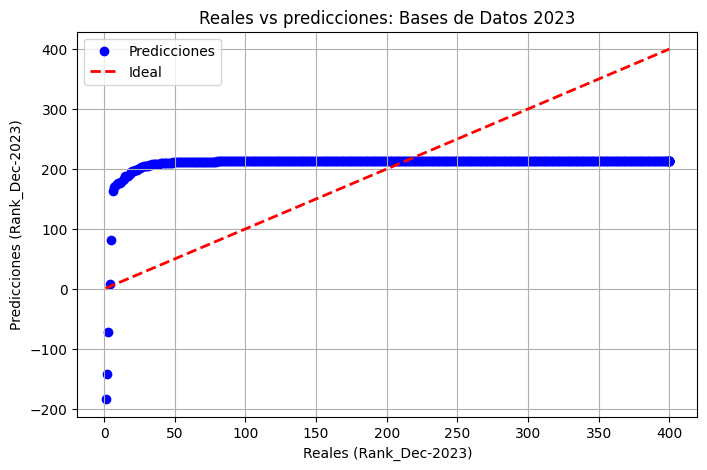


Para 2024 columnas: Score='Score_Dec-2024', Rank='Rank_Dec-2024'

Modelo para: BASES DE DATOS 2024
R^2: 0.0674
MSE: 13486.1699


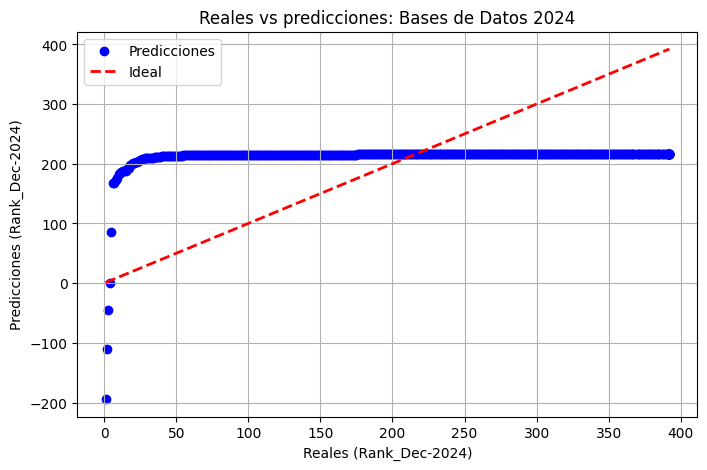


Para 2025 columnas: Score='Score_May-2025', Rank='Rank_May-2025'

Modelo para: BASES DE DATOS 2025
R^2: 0.0708
MSE: 13280.9142


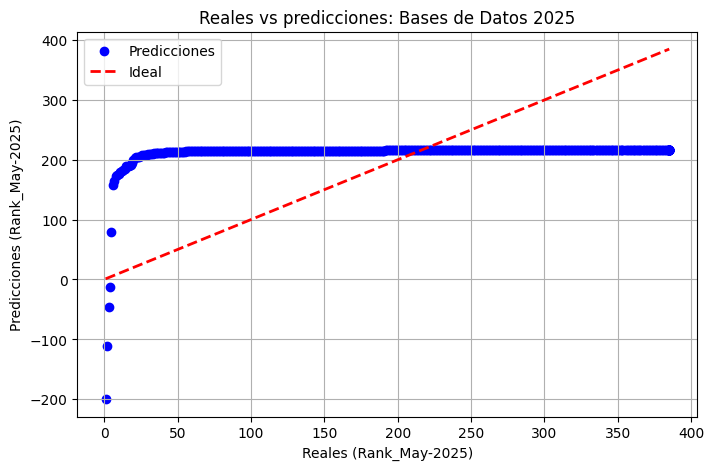

In [32]:
def descargar_tiobe_top20():
    url = "https://www.tiobe.com/tiobe-index/"
    resp = requests.get(url)
    if resp.status_code != 200:
        raise Exception("Error al descargar la página TIOBE")
    soup = BeautifulSoup(resp.text, "html.parser")

    tablas = soup.find_all("table")
    target_table = None
    for tabla in tablas:
        headers = [th.text.strip() for th in tabla.find_all("th")]
        if any("Programming Language" in h for h in headers):
            target_table = tabla
            break
    if target_table is None:
        raise Exception("No se encontró la tabla de lenguajes en TIOBE")

    filas = target_table.find_all("tr")[1:]
    datos = []

    def safe_float(val):
        try:
            val = val.strip().replace('%', '').replace('+', '').replace(',', '')
            return float(val) if val else np.nan
        except:
            return np.nan

    for fila in filas:
        cols = fila.find_all("td")
        if len(cols) < 5:
            continue
        datos.append({
            "Position": int(cols[0].text.strip()),
            "Language": cols[1].text.strip(),
            "Popularity (%)": safe_float(cols[2].text),
            "Annual Change (%)": safe_float(cols[3].text),
            "Projection (%)": safe_float(cols[4].text)
        })
    df = pd.DataFrame(datos)
    df.dropna(subset=["Popularity (%)", "Annual Change (%)", "Projection (%)"], inplace=True)
    return df

def cargar_csv_url(url):
    r = requests.get(url)
    if r.status_code != 200:
        raise Exception(f"No se pudo descargar CSV de {url}")
    return pd.read_csv(StringIO(r.text))

def entrenar_modelo(df, nombre, col_X1, col_X2, col_y):
    print(f"\nModelo para: {nombre.upper()}")

    if col_X1 not in df.columns or col_X2 not in df.columns or col_y not in df.columns:
        print(f"Columnas requeridas no encontradas: {col_X1}, {col_X2}, {col_y}")
        return

    X = df[[col_X1, col_X2]]
    y = df[col_y]

    mask = ~(X.isna().any(axis=1) | y.isna())
    X_clean = X[mask]
    y_clean = y[mask]

    if X_clean.empty or y_clean.empty:
        print("No hay suficientes datos para entrenar el modelo (todos NaN).")
        return

    modelo = LinearRegression()
    modelo.fit(X_clean, y_clean)

    y_pred = modelo.predict(X_clean)

    r2 = r2_score(y_clean, y_pred)
    mse = mean_squared_error(y_clean, y_pred)
    print(f"R^2: {r2:.4f}")
    print(f"MSE: {mse:.4f}")

    plt.figure(figsize=(8,5))
    plt.scatter(y_clean, y_pred, color='blue', label='Predicciones')
    plt.plot([y_clean.min(), y_clean.max()], [y_clean.min(), y_clean.max()], 'r--', lw=2, label='Ideal')
    plt.xlabel(f'Reales ({col_y})')
    plt.ylabel(f'Predicciones ({col_y})')
    plt.title(f"Reales vs predicciones: {nombre}")
    plt.legend()
    plt.grid(True)
    plt.show()

def entrenar_modelo_simple(df, nombre, col_X, col_y):
    print(f"\nModelo para: {nombre.upper()}")

    if col_X not in df.columns or col_y not in df.columns:
        print(f"Columnas requeridas no encontradas: {col_X}, {col_y}")
        return

    X = df[[col_X]]
    y = df[col_y]

    mask = ~(X.isna().any(axis=1) | y.isna())
    X_clean = X[mask]
    y_clean = y[mask]

    if X_clean.empty or y_clean.empty:
        print("No hay suficientes datos para entrenar el modelo (todos NaN).")
        return

    modelo = LinearRegression()
    modelo.fit(X_clean, y_clean)

    y_pred = modelo.predict(X_clean)

    r2 = r2_score(y_clean, y_pred)
    mse = mean_squared_error(y_clean, y_pred)
    print(f"R^2: {r2:.4f}")
    print(f"MSE: {mse:.4f}")

    plt.figure(figsize=(8,5))
    plt.scatter(y_clean, y_pred, color='blue', label='Predicciones')
    plt.plot([y_clean.min(), y_clean.max()], [y_clean.min(), y_clean.max()], 'r--', lw=2, label='Ideal')
    plt.xlabel(f'Reales ({col_y})')
    plt.ylabel(f'Predicciones ({col_y})')
    plt.title(f"Reales vs predicciones: {nombre}")
    plt.legend()
    plt.grid(True)
    plt.show()

urls_dbs = {
    "2023": "https://raw.githubusercontent.com/birdflyi/db_engines_ranking_table_crawling/main/data/db_engines_ranking_table_full/ranking_crawling_202312_automerged.csv",
    "2024": "https://raw.githubusercontent.com/birdflyi/db_engines_ranking_table_crawling/main/data/db_engines_ranking_table_full/ranking_crawling_202412_automerged.csv",
    "2025": "https://raw.githubusercontent.com/birdflyi/db_engines_ranking_table_crawling/main/data/db_engines_ranking_table_full/ranking_crawling_202505_automerged.csv"
}

print("Descargando datos TIOBE top 20...")
df_lang = descargar_tiobe_top20()
print(df_lang.head())

df_dbs = {}
for year, url in urls_dbs.items():
    print(f"\nDescargando datos Bases de Datos para {year}...")
    df = cargar_csv_url(url)
    print(f"Columnas disponibles para {year}:\n{df.columns.tolist()}")
    df_dbs[year] = df

entrenar_modelo(df_lang,
               nombre="Lenguajes de Programación",
               col_X1="Popularity (%)",
               col_X2="Annual Change (%)",
               col_y="Projection (%)")

for year in ["2023", "2024", "2025"]:
    df = df_dbs[year]
    score_col = None
    rank_col = None
    for c in df.columns:
        if "Score" in c:
            score_col = c
        if "Rank" in c:
            rank_col = c

    print(f"\nPara {year} columnas: Score='{score_col}', Rank='{rank_col}'")

    if score_col and rank_col:
        entrenar_modelo_simple(df,
                              nombre=f"Bases de Datos {year}",
                              col_X=score_col,
                              col_y=rank_col)
    else:
        print(f"No se encontraron todas las columnas necesarias para entrenar modelo en {year}.")